In [4]:
% matplotlib inline
import bayleaf as bf
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import theano
import theano.tensor as tt
import pandas as pd
FLOAT_EPS = np.finfo(float).eps
np.random.seed(34333823)

# Simulate Data

In [5]:
# Copula 

# Test Copula Model
# Im
## Generated Dataset
import pandas as pd
n = 2500
β1 = np.array([1.63, 0.03])
β2 = np.array([0.8, 0.03])
#β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2])
λk = np.array([0.0047, 0.0037])
ρk = np.array([0.716, .725])
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)

X = sim_simple_covs(n)
exp_1 = np.exp(np.dot(X,βs.T))[:,0]
exp_2 = np.exp(np.dot(X,βs.T))[:,1]

α = 3.210
λ_s = λk[0]
ρ_s = ρk[0]
r_s =0.5

λ_t = λk[1]
ρ_t = ρk[1]
r_t =1.5

U_s = np.random.uniform(size=n)
S = ((U_s**(-r_s)-1)/(r_s*exp_1*λ_s))**(1/ρ_s)
U_t = np.random.uniform(size=n)
S_T = ((U_t**(-(α)/(α+1))-1)*(U_s)**(-α)+1)**(-α**(-1))
T = ((S_T**(-r_t)-1)/(r_t*exp_2*λ_t))**(1/ρ_t)

Te = np.vstack([S,T]).T
cens_end = 7500
maxtime = 500
Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime

Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime
results = np.repeat(0, n)
names_df = ["del"]
# loop over levels
for level in range(2):
    obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
    names_df = np.append(names_df, "time_"+str(level+1))
    delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
    names_df = np.append(names_df, "delta_"+str(level+1))
    results = np.vstack((results, obs_t))
    results = pd.DataFrame(np.vstack((results, delta)))
#
x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
names_df = np.append(names_df, x_names)
#names_df = np.append(names_df, "frailty") # now add frailty
out = pd.DataFrame(np.vstack((results, X.T)).T)
out.columns = names_df
out = out.iloc[:, out.columns!="del"]



In [6]:
with bf.pm.Model() as test_run:
    bf.Copula.from_formula(formula = "([time_1, time_2],[delta_1, delta_2])~X_1+X_2-1", data = out, family = "clayton_trans")
    MAP = bf.pm.find_MAP()


logp = -19,443, ||grad|| = 64.568: 100%|██████████| 340/340 [00:01<00:00, 170.88it/s] 


In [7]:
with test_run:
    trace = bf.pm.sample(2000, tune =6000, start =MAP)

100%|██████████| 8000/8000 [39:12<00:00,  3.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f340668>,
      dtype=object)

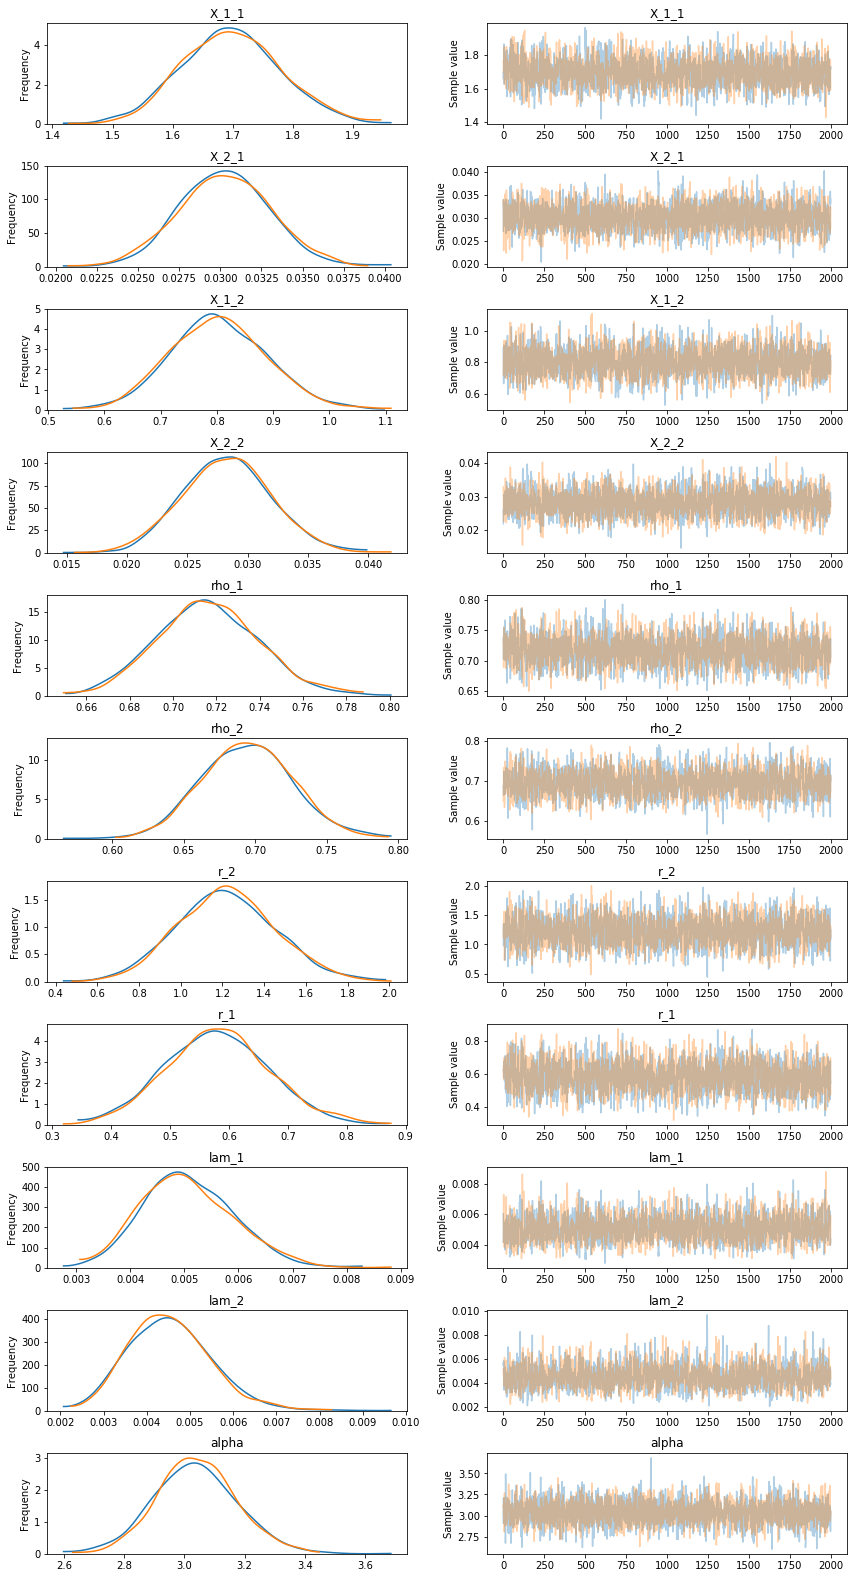

In [9]:
pm.traceplot(trace)

In [10]:
results = round(pm.summary(trace),3)
print(results.to_latex(escape=False,column_format='cccccc',index=True,))


\begin{tabular}{cccccc}
\toprule
{} &   mean &     sd &  mc_error &  hpd_2.5 &  hpd_97.5 &     n_eff &   Rhat \\
\midrule
X_1_1 &  1.697 &  0.081 &     0.002 &    1.551 &     1.861 &  2001.362 &  1.001 \\
X_2_1 &  0.030 &  0.003 &     0.000 &    0.025 &     0.036 &  2635.499 &  1.000 \\
X_1_2 &  0.802 &  0.085 &     0.002 &    0.635 &     0.966 &  2334.185 &  1.000 \\
X_2_2 &  0.028 &  0.004 &     0.000 &    0.021 &     0.035 &  2405.465 &  1.000 \\
rho_1 &  0.716 &  0.023 &     0.000 &    0.671 &     0.764 &  2052.493 &  1.000 \\
rho_2 &  0.694 &  0.032 &     0.001 &    0.633 &     0.758 &  2206.285 &  1.000 \\
r_2   &  1.218 &  0.234 &     0.005 &    0.749 &     1.666 &  2210.307 &  1.000 \\
r_1   &  0.580 &  0.087 &     0.002 &    0.396 &     0.742 &  2089.963 &  1.001 \\
lam_1 &  0.005 &  0.001 &     0.000 &    0.004 &     0.007 &  2027.818 &  1.000 \\
lam_2 &  0.005 &  0.001 &     0.000 &    0.003 &     0.006 &  1956.398 &  1.000 \\
alpha &  3.037 &  0.134 &     0.002 &    2.779 &

In [11]:
### Frailty Model 

n = 5000
## generate gamma frailty according to parameters \theta^{-1}
theta = .510
## generate gamma frailty term, ~Γ(θ^{-1},θ), np parameterizes with scale, so
### In later versions of this, we merge this within the data generator
## functionalize this
β1 = np.array([0.63, 0.03])
β2 = np.array([0.8, 0.03])
β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2,β3])
k=3
λk = np.array([0.0047, 0.0037, 0.0057])
ρk = np.array([0.716, .725, .73])

r_true = .5
r_this = .5
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)
X = sim_simple_covs(n)
# Simulate Survival Times, generalize for k categories
def sim_weibull_frail_generalized(betas, theta, X, lam, r, rho, maxtime, cens_end, n, k, first = False):
    '''
    Function to simulate transformed weibull survival times with uniform censoring according to the weibull PH model
    Parameters
    ----------
    betas : effect sizes
    lam : scale parameters for different levels (must be dimension kx1)
    theta : parameter of gamma distribution of frailties
    rho : shape parameters for each level (kx1)
    X : covariates
    maxtime : maximum study time
    r : transformation parameter
    k : number of outcomes
    first : boolean, do we want to return just the time to first event
    '''
    w = np.random.gamma(size = n, shape=theta**(-1), scale = theta)
    ## from probability integral transform
    Te = ((np.exp(-(np.log(np.random.uniform(size=(n,k)))*r)/w[:,None])-1)/(r*lam*np.exp(np.dot(X,betas.T))))**(1/rho)
    # Do we want time to first event r?
    # generate censoring time, unif and truncated by tau
    if first == True:
        Cens = 1+cens_end*np.random.uniform(size = n)
        Cens[Cens>maxtime] = maxtime
        alltimes = np.vstack((Cens,Te.T)).T
        eventType = []
        for i in range(len(w)):
            eventType.append(np.where(alltimes[i,]==np.amin(alltimes[i,]))[0][0])
        obs_t = list(np.amin(alltimes,axis = 1))
        out = pd.DataFrame(np.array([obs_t, eventType, pd.Series(X[:,[0]][:,0]),pd.Series(X[:,[1]][:,0]),w])).T
        # Clean up for the covariates
        out.columns = ["obs_t", "eventType", "sex", "age", "sim_frail"]
    else:
        Cens = 1+cens_end*np.random.uniform(size = (n,k))
        Cens[Cens>maxtime] = maxtime
        results = np.repeat(0, n)
        names_df = ["del"]
        # loop over levels
        for level in range(k):
            obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
            names_df = np.append(names_df, "time_"+str(level+1))
            delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
            names_df = np.append(names_df, "delta_"+str(level+1))
            results = np.vstack((results, obs_t))
            results = pd.DataFrame(np.vstack((results, delta)))
        # Names of X
        x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
        names_df = np.append(names_df, x_names)
        names_df = np.append(names_df, "frailty") # now add frailty
        out = pd.DataFrame(np.vstack((results, X.T, w.T)).T)
        out.columns = names_df
        out = out.iloc[:, out.columns!="del"] # get rid of extra column
    return(out)
## NOW ACTUALLY GENERATE THE DATA, this is the intitialization step
X = sim_simple_covs(n)
data = sim_weibull_frail_generalized(betas=βs,
                              theta = theta,
                              X = X,
                              lam = λk,
                              rho = ρk,
                              maxtime=200,
                              cens_end = 300,
                              r = r_true ,k=3, first=False, n=n)

In [13]:
with pm.Model() as model_test2:
    bf.Frailty.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', data = data)
    MAP = pm.find_MAP()
    trace_frail = pm.sample(3000, tune =3000, start = MAP)

logp = -34,670, ||grad|| = 6.4942: 100%|██████████| 460/460 [00:03<00:00, 115.34it/s] 
100%|██████████| 6000/6000 [26:51<00:00,  3.72it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2298c198>,
      dtype=object)

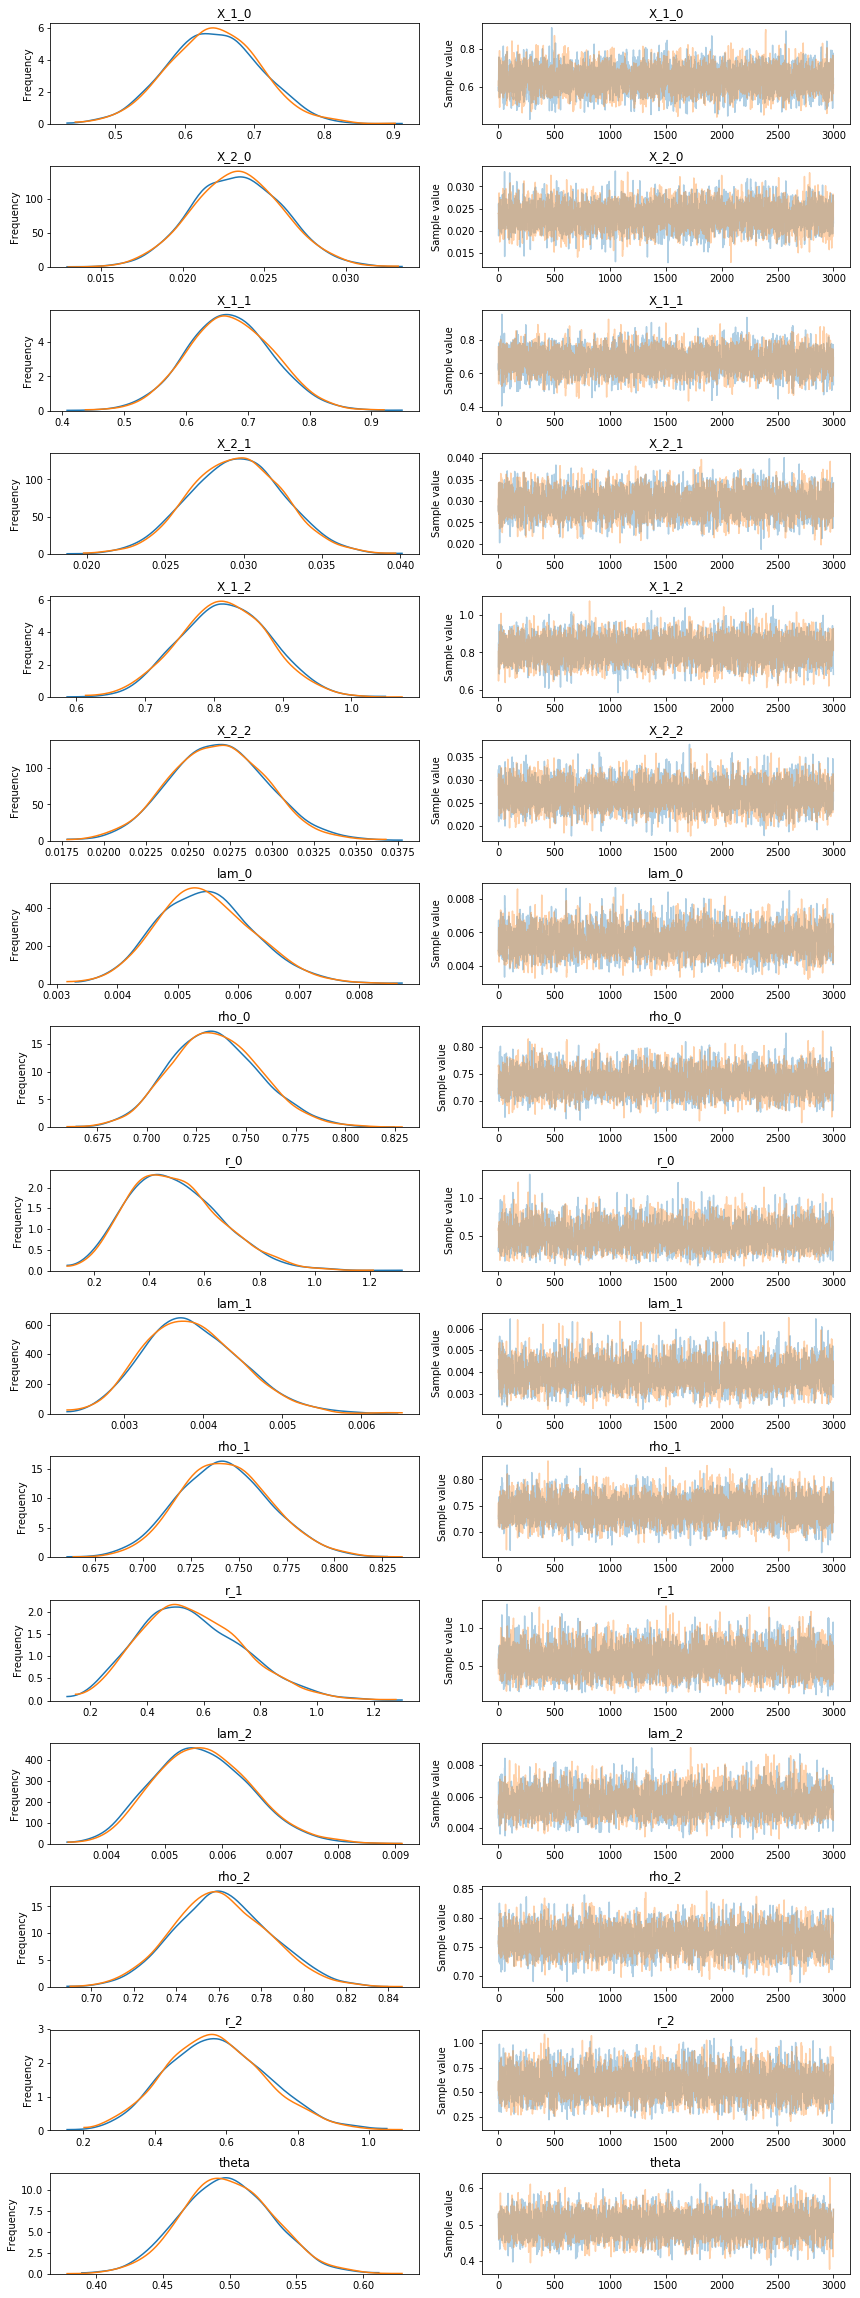

In [14]:
pm.traceplot(trace_frail)

In [15]:
results_frail = round(pm.summary(trace_frail),3)
print(results_frail.to_latex(escape=False,column_format='cccccc',index=True,))


\begin{tabular}{cccccc}
\toprule
{} &   mean &     sd &  mc_error &  hpd_2.5 &  hpd_97.5 &     n_eff &   Rhat \\
\midrule
X_1_0 &  0.642 &  0.065 &     0.001 &    0.516 &     0.771 &  4973.696 &  1.000 \\
X_2_0 &  0.023 &  0.003 &     0.000 &    0.018 &     0.029 &  4742.978 &  1.000 \\
X_1_1 &  0.672 &  0.069 &     0.001 &    0.534 &     0.801 &  5274.401 &  1.000 \\
X_2_1 &  0.030 &  0.003 &     0.000 &    0.024 &     0.035 &  3786.813 &  1.000 \\
X_1_2 &  0.816 &  0.065 &     0.001 &    0.693 &     0.945 &  4719.671 &  1.000 \\
X_2_2 &  0.027 &  0.003 &     0.000 &    0.021 &     0.033 &  4061.566 &  1.000 \\
lam_0 &  0.005 &  0.001 &     0.000 &    0.004 &     0.007 &  3882.002 &  1.000 \\
rho_0 &  0.735 &  0.022 &     0.000 &    0.693 &     0.780 &  4066.090 &  1.000 \\
r_0   &  0.494 &  0.166 &     0.003 &    0.195 &     0.821 &  3971.375 &  1.000 \\
lam_1 &  0.004 &  0.001 &     0.000 &    0.003 &     0.005 &  2877.305 &  1.000 \\
rho_1 &  0.743 &  0.024 &     0.000 &    0.698 &